In [1]:
%cd ..

/home/ec2-user/uclresearchanalysis


In [2]:
%matplotlib inline
import builtins
# builtins.uclresearch_topic = 'GIVENCHY' #0 -- Finished
builtins.uclresearch_topic = 'HAWKING' #0 -- Finished
# builtins.uclresearch_topic = 'NYC' # 88001
# builtins.uclresearch_topic = 'FLORIDA' # 448387
from configuration import config
from configuration.config import load_ml_data
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
import numpy as np
import matplotlib.pyplot as plt

('Reading config file from location: '
 '/home/ec2-user/uclresearchanalysis/configuration/env.properties')
{'calculate': {'analysis': True,
               'friends': True,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-13', '2018-03-14', '2018-03-15'],
          'eventname': "hawking's death",
          'phrases': ['stephen%20hawking%20death',
                      'stephen%20hawking%20die',
                      'stephen%20hawking%20passed%20away'],
          'starttime': 'Mar 13 12:00:00 -0500 2018'},
 'path': {'cwd': '/home/ec2-user/uclresearchanalysis/data/hawking',
          'ml': '/home/ec2-user/uclresearchanalysis/data/hawking/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/hawking/pickle/networkx_all.dat',
                       'friends': '/home/ec2-user/uclresearchanalysis/data/hawking/pickle/networkx_friends.dat',
                       'potential': '/home/

In [3]:
# Parameters
interval = 30

# 1. Prepare
def prepare_data(interval):
    df = load_ml_data(interval)
    df = df.reset_index(drop=True)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y


Loading data file from path /home/ec2-user/uclresearchanalysis/data/hawking/pickle/30_data.dat
'Loaded 4828104 entires'
[Original] data counts, with uninfected (0): 1821013, infected (1): 3007091


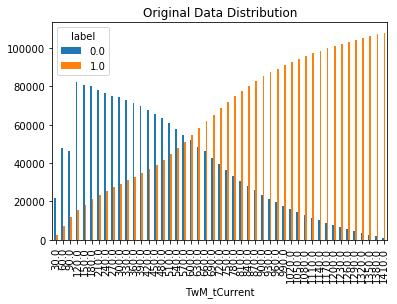

In [4]:
# 1. Prepare
df, X, y = prepare_data(interval)

In [ ]:
len(X.columns)

In [5]:
def train(df, X, y, model, n_folds, is_xgb):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
#     number_of_features = len(X.columns)
    number_of_features = 60

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance (Up-sampling)
        diff = sum(train_fold.label == 1) - sum(train_fold.label == 0)
        append_indices = np.random.choice(train_fold[train_fold.label == 0].index, diff, replace=True)
        new_sample = train_fold.loc[append_indices,:]
        train_fold = pd.concat([train_fold, new_sample])
        train_fold = train_fold.reset_index(drop=True)
        print('[Up-sampling] data counts, with uninfected (0): {}, infected (1): {}'.format(
            train_fold['label'].value_counts()[0],
            train_fold['label'].value_counts()[1],
        ))
        
        # 4. Feature Selection
        corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
        corr = corr.sort_values(ascending=False)
        corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)

        features = corr.index[range(number_of_features)].values
#         train_fold_input  = SelectKBest(chi2, k=50).fit_transform(train_fold[X.columns], train_fold['label'])

        train_fold_input = train_fold[features]
        train_fold_output = train_fold['label']
        
        # 5. Training
        # Fit logistic regression
        if is_xgb:
            xgtrain = xgb.DMatrix(train_fold_input.values, train_fold_output.values)
#             evallist = [(xgtest, 'eval'), (xgtrain, 'train')]
            evallist = [(xgtrain, 'train')]
            bst = xgb.train(model, xgtrain, 50, evallist)
        else:
            model.fit(train_fold_input, train_fold_output)

        # 6. Testing
        # Check MSE on test set
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
        if is_xgb:
            xgtest = xgb.DMatrix(test_fold[features].values)
            xgtest_t = xgb.DMatrix(test_fold_t[features].values)
            pred = bst.predict(xgtest)
            pred_t = bst.predict(xgtest_t)
        else:
            pred = model.predict(test_fold[features])
            pred_t = model.predict(test_fold_t[features])
        mse.append(mean_squared_error(test_fold.label, pred))
        roc.append(roc_auc_score(test_fold.label, pred))
        auc_t.append(roc_auc_score(test_fold_t.label, pred_t))

        acc.append(accuracy_score(test_fold.label, (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t.label, (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold.label,(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold.label, (pred>0.5).astype(int))
        print(cm)

        # Done with the fold
        fold_count += 1
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())
    return model

In [ ]:
#xgboost
param = {'max_depth': 12, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 12
param['eval_metric'] = ['auc']

train(df, X, y, param, 10, 1)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 2706381, infected (1): 2706381
[0]	train-auc:0.891185
[1]	train-auc:0.899175
[2]	train-auc:0.903683
[3]	train-auc:0.907246
[4]	train-auc:0.911191
[5]	train-auc:0.914863
[6]	train-auc:0.918542
[7]	train-auc:0.921645
[8]	train-auc:0.924889
[9]	train-auc:0.928864
[10]	train-auc:0.932099
[11]	train-auc:0.934694
[12]	train-auc:0.937249
[13]	train-auc:0.939414
[14]	train-auc:0.941945
[15]	train-auc:0.944416
[16]	train-auc:0.946463
[17]	train-auc:0.949333
[18]	train-auc:0.951925
[19]	train-auc:0.953697
[20]	train-auc:0.956045
[21]	train-auc:0.957464
[22]	train-auc:0.959672
[23]	train-auc:0.960896
[24]	train-auc:0.962387
[25]	train-auc:0.964062
[26]	train-auc:0.965781
[27]	train-auc:0.967496
[28]	train-auc:0.968721
[29]	train-auc:0.970342
[30]	train-auc:0.971429
[31]	train-auc:0.972486
[32]	train-auc:0.973601
[33]	train-auc:0.974743
[34]	train-auc:0.975647
[35]	train-auc:0.976535
[36]	train-auc:0.977

/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[0]	train-auc:0.891471
[1]	train-auc:0.899362
[2]	train-auc:0.903684
[3]	train-auc:0.907872
[4]	train-auc:0.912252
[5]	train-auc:0.91532
[6]	train-auc:0.918096
[7]	train-auc:0.92076
[8]	train-auc:0.924249
[9]	train-auc:0.927369
[10]	train-auc:0.930915
[11]	train-auc:0.933494
[12]	train-auc:0.936576
[13]	train-auc:0.939549
[14]	train-auc:0.94197
[15]	train-auc:0.943712
[16]	train-auc:0.945798
[17]	train-auc:0.94749
[18]	train-auc:0.949016
[19]	train-auc:0.952157
[20]	train-auc:0.95383
[21]	train-auc:0.956118
[22]	train-auc:0.958365


In [14]:
# Naive Bayes
train(df, X, y, GaussianNB(), 10)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 2706381, infected (1): 2706381
[[145577  36525]
 [ 87797 212913]]
===Processing fold 1===
[Up-sampling] data counts, with uninfected (0): 2706382, infected (1): 2706382


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[145539  36563]
 [ 86937 213772]]
===Processing fold 2===
[Up-sampling] data counts, with uninfected (0): 2706382, infected (1): 2706382
[[146445  35657]
 [ 87765 212944]]
===Processing fold 3===
[Up-sampling] data counts, with uninfected (0): 2706382, infected (1): 2706382
[[145853  36248]
 [ 87114 213595]]
===Processing fold 4===
[Up-sampling] data counts, with uninfected (0): 2706382, infected (1): 2706382
[[145845  36256]
 [ 86843 213866]]
===Processing fold 5===
[Up-sampling] data counts, with uninfected (0): 2706382, infected (1): 2706382
[[146051  36050]
 [ 87822 212887]]
===Processing fold 6===
[Up-sampling] data counts, with uninfected (0): 2706382, infected (1): 2706382
[[145768  36333]
 [ 87469 213240]]
===Processing fold 7===
[Up-sampling] data counts, with uninfected (0): 2706382, infected (1): 2706382
[[146049  36052]
 [ 87107 213602]]
===Processing fold 8===
[Up-sampling] data counts, with uninfected (0): 2706382, infected (1): 2706382
[[145531  36570]
 [ 86535 214174]]

GaussianNB(priors=None)

In [7]:
# Logistic Regression
train(df, X, y, LogisticRegression(), 10)


Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3736   851]
 [ 4340 13772]]
===Processing fold 1===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[ 3719   868]
 [ 4340 13772]]
===Processing fold 2===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3744   843]
 [ 4321 13791]]
===Processing fold 3===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3687   900]
 [ 4406 13706]]
===Processing fold 4===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003
[[ 3694   893]
 [ 4432 13680]]
===Processing fold 5===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3739   848]
 [ 4457 13654]]
===Processing fold 6===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3736   851]
 [ 4390 13721]]
===Processing fold 7===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3752   835]
 [ 4361 13750]]
===Processing fold 8===
[Up-sampling] data counts, with uninfected (0): 163004, infected (1): 163004
[[ 3696   891]
 [ 4367 13744]]
===Processing fold 9===
[Up-sampling] data co

In [15]:
# Random Forest 10 folds
rf_10 = train(df, X, y, RandomForestClassifier(n_estimators= 100,min_samples_split=2,
                                  min_samples_leaf=1,random_state=10), 10)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 2706381, infected (1): 2706381
[[173345   8757]
 [ 15748 284962]]
===Processing fold 1===


MemoryError: 

In [12]:
rf_2 = train(df, X, y, RandomForestClassifier(n_estimators= 100,min_samples_split=2,
                                  min_samples_leaf=1,random_state=10), 2)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 90557, infected (1): 90557
[[20510  2425]
 [ 3544 87014]]
===Processing fold 1===
[Up-sampling] data counts, with uninfected (0): 90558, infected (1): 90558


/home/ec2-user/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[[19810  3124]
 [ 4317 86240]]
Finished cross validation
MSE: 0    0.059079
dtype: float64 
ACC: 0    0.940921
dtype: float64 
AUC: 0    0.917811
dtype: float64 
F1: 0    0.962741
dtype: float64 
ACC for t at 210: 0    0.792842
dtype: float64 
                                                 cv0       cv1  average corr
TwM_t0                                      0.624205  0.625142      0.624673
TwM_tCurrent                                0.622063  0.624017      0.623040
Stat_average_t                              0.609606  0.610090      0.609848
TwM_t-1                                     0.537956  0.537945      0.537950
Nw_outDegreeCentrality-1                    0.204178  0.208046      0.206112
Nw_degreeCentrality-1                       0.199932  0.203934      0.201933
Stat_min_kOut                               0.197963  0.198967      0.198465
Nw_betweennessCentrality-1                  0.184304  0.188412      0.186358
Stat_average_kOut                           0.171815  0.173698 

In [18]:
importances=rf_10.feature_importances_

In [17]:
rf_2.feature_importances_

array([0.11437357, 0.1255083 , 0.0985373 , 0.07220299, 0.0081229 ,
       0.00850846, 0.01203892, 0.00558541, 0.0096856 , 0.00433541,
       0.00625913, 0.00650834, 0.01107941, 0.0057833 , 0.01003228,
       0.00530494, 0.00878706, 0.01013125, 0.00537493, 0.0149048 ,
       0.00829611, 0.00511146, 0.00151205, 0.00659626, 0.00151777,
       0.0016192 , 0.00156393, 0.00160628, 0.00146474, 0.0018072 ,
       0.00161766, 0.00170088, 0.00153224, 0.0015575 , 0.00137469,
       0.00152368, 0.00154734, 0.00801275, 0.05387167, 0.00627333,
       0.00924356, 0.05388909, 0.00178274, 0.00781696, 0.00577942,
       0.02387744, 0.00138614, 0.01449663, 0.00879068, 0.00220879,
       0.00593977, 0.00578732, 0.00865982, 0.05753796, 0.00972171,
       0.00162264, 0.05791569, 0.0065575 , 0.05501204, 0.00880309])

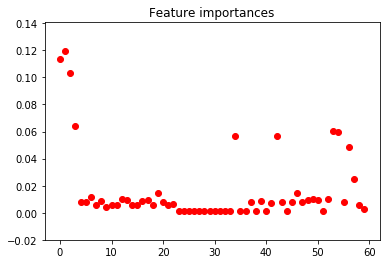

In [30]:
plt.figure()
plt.title("Feature importances")
plt.scatter(range(0,60), importances,  color="r")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

In [15]:
# GBDT
train(df, X, y, GradientBoostingClassifier(n_estimators=150, min_samples_split=30,
                                  min_samples_leaf=2,max_depth=12,max_features='sqrt', subsample=0.8,random_state=10), 10)

Start cross validation
===Processing fold 0===
[Up-sampling] data counts, with uninfected (0): 163003, infected (1): 163003


KeyboardInterrupt: 

In [ ]:
#xgb model
param = {'max_depth':5, 'eta':1, 'objective':'binary:logistic'}
num_round = 20
